In [420]:
import pandas as pd
import boto3
# import S3FS
import os.path
from pathlib import Path
from pyspark.sql import SparkSession
from boto3.session import Session
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.pyplot import figure
from helper_func import *
pd.set_option('display.max_rows', None)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


In [421]:
data = pd.read_csv("emscad_v1.csv")

In [422]:
data.to_pickle("data.pkl")

In [423]:
data.drop("in_balanced_dataset", inplace = True, axis = 1)

In [424]:
data["fraudulent"] = data["fraudulent"].replace(["f" , "t"], ["Not Fraud", "Fraud"])

In [425]:
fraud_prop = data.groupby("fraudulent").size().reset_index(name = "counts")
x = np.array(fraud_prop.iloc[:,0])
y = np.array(fraud_prop.iloc[:,1])
total = y.sum()

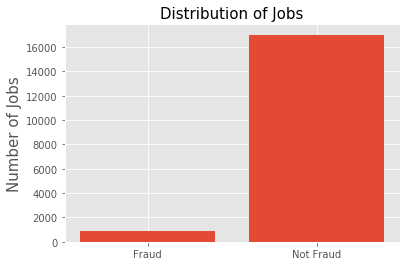

In [426]:
fig = plt.figure()
plt.bar(x, y) 
plt.ylabel("Number of Jobs", fontsize=15) 
plt.title("Distribution of Jobs", fontsize=15)
fig.savefig('images/fraud.png', bbox_inches='tight');

<Figure size 432x288 with 0 Axes>

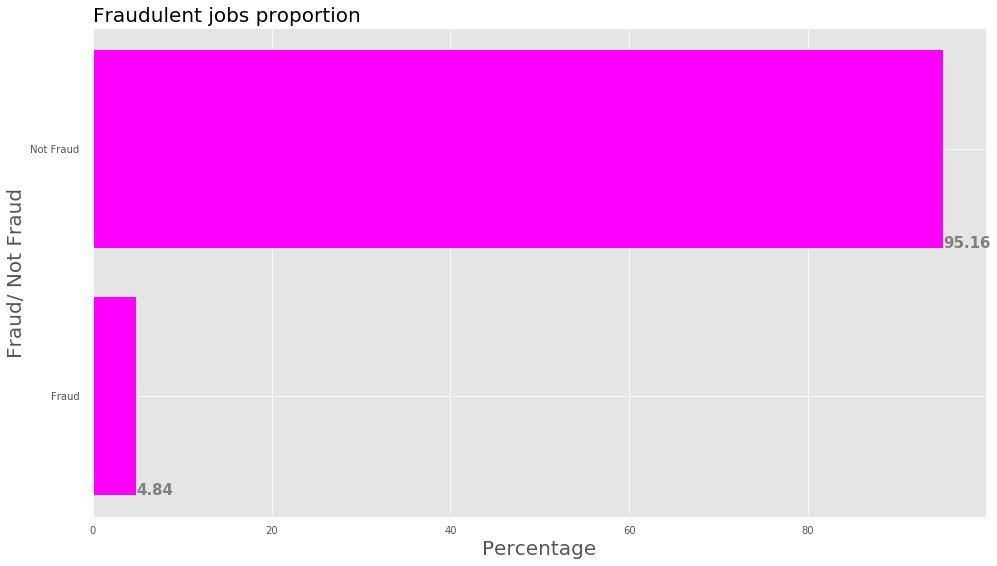

In [427]:
# fraud distribution percentages
fig = plt.figure()
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y*100/total, color="magenta")
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10)
for i in ax.patches: 
    plt.text(i.get_width(), i.get_y(),  
             str(round((i.get_width()), 2)), 
             fontsize = 15, fontweight ='bold', 
             color ='grey')
    
ax.set_title("Fraudulent jobs proportion", 
             loc ='left', fontsize =20) 
ax.set_ylabel("Fraud/ Not Fraud", fontsize =20)
ax.set_xlabel("Percentage", fontsize =20)
fig.savefig('images/fraud_perc.png', bbox_inches='tight')

In [428]:
data["fraudulent"] = data["fraudulent"].replace(["Not Fraud", "Fraud"], [0,1])

binary_cols = ["telecommuting", "has_company_logo","has_questions"]

for col in binary_cols:
    binarize(data,col)



In [429]:
fill_nulls(data)

<Figure size 432x288 with 0 Axes>

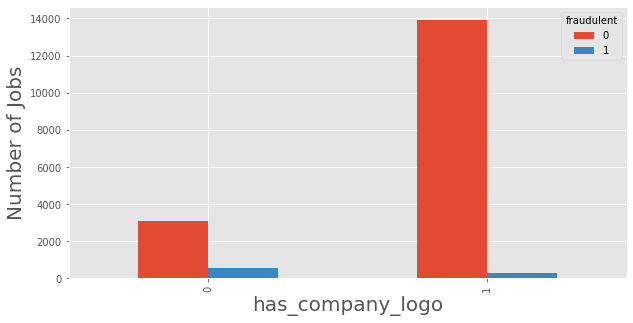

<Figure size 432x288 with 0 Axes>

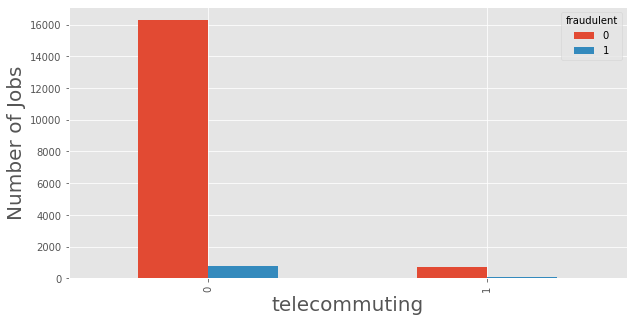

<Figure size 432x288 with 0 Axes>

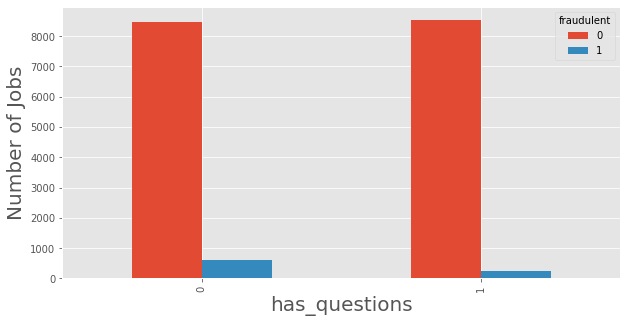

<Figure size 432x288 with 0 Axes>

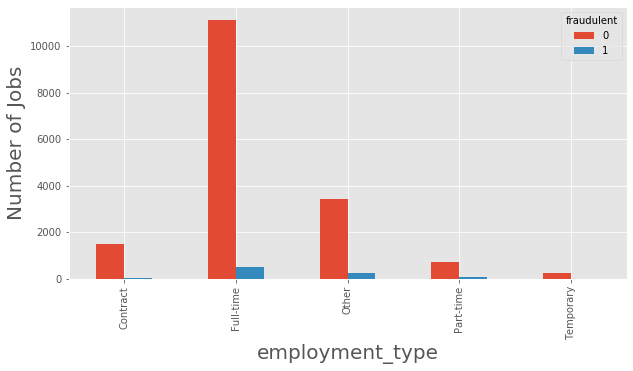

In [430]:
cols = ["has_company_logo","telecommuting", "has_questions", "employment_type" ]

for col in cols:
    plot_bar(data,col)

In [431]:
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]

for col in text_cols:
    clean_cols(data,col)


<Figure size 432x288 with 0 Axes>

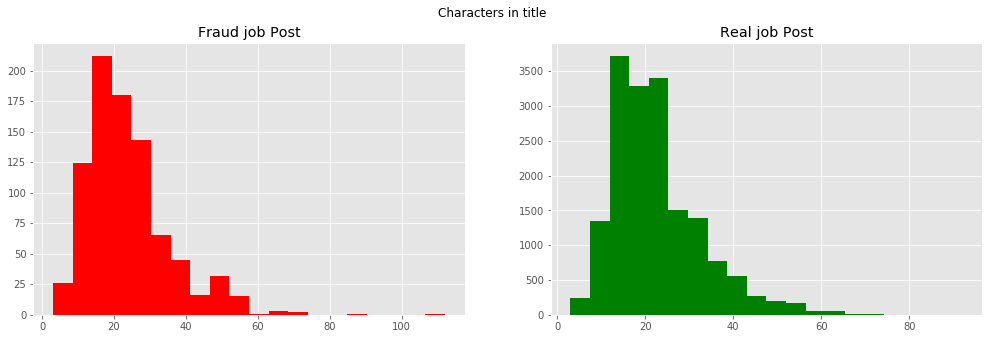

<Figure size 432x288 with 0 Axes>

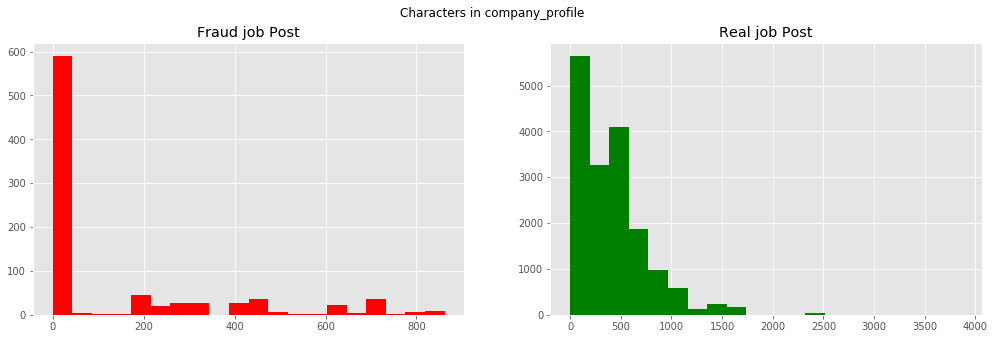

<Figure size 432x288 with 0 Axes>

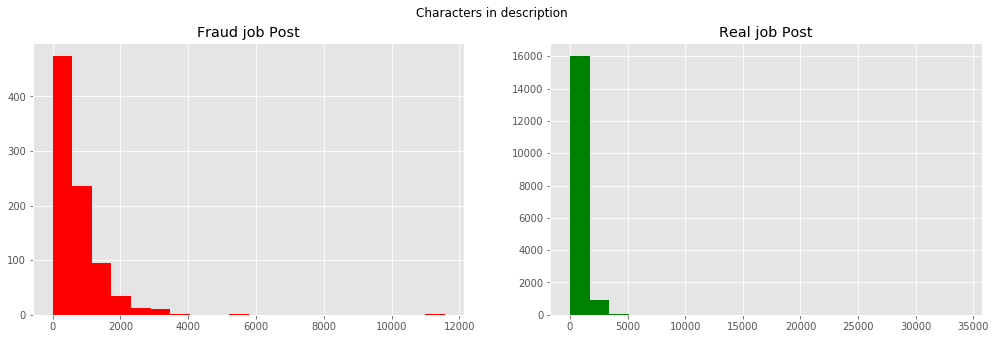

<Figure size 432x288 with 0 Axes>

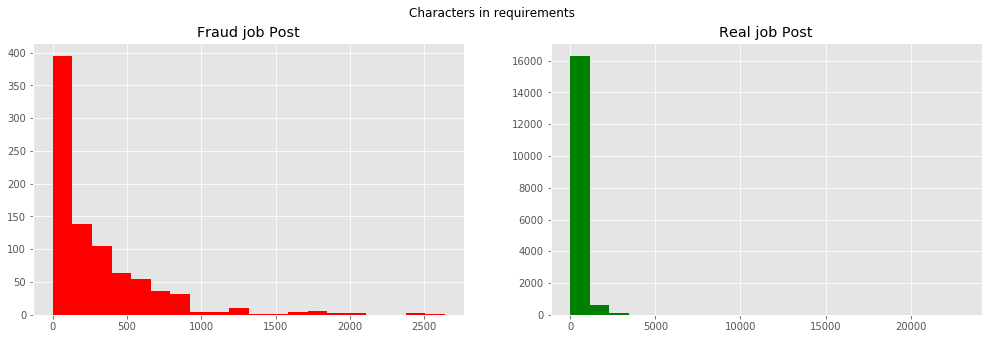

<Figure size 432x288 with 0 Axes>

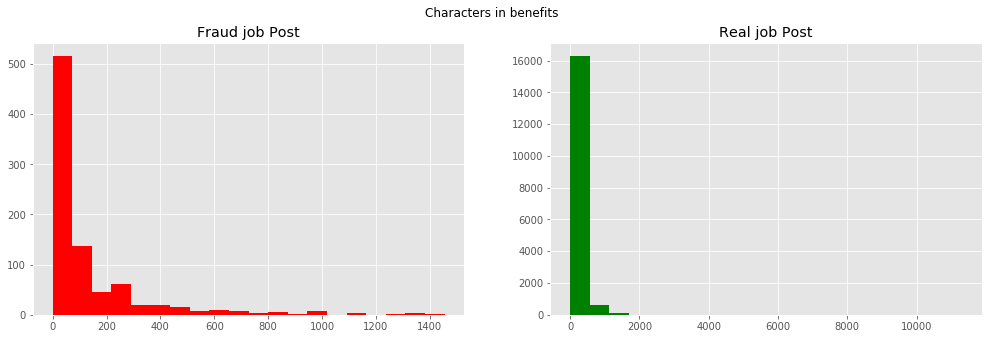

In [432]:
for col in text_cols:
    plot_text(data, col)

<Figure size 432x288 with 0 Axes>

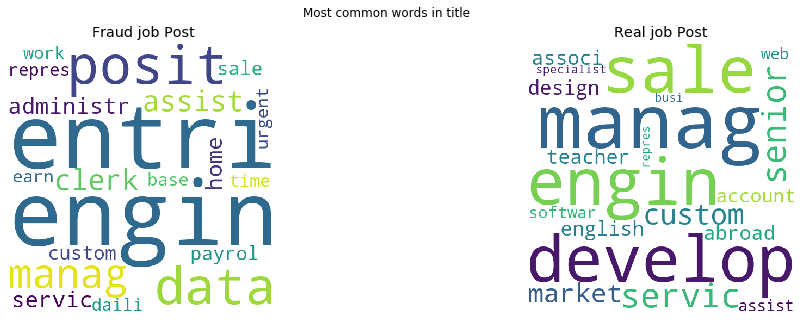

<Figure size 432x288 with 0 Axes>

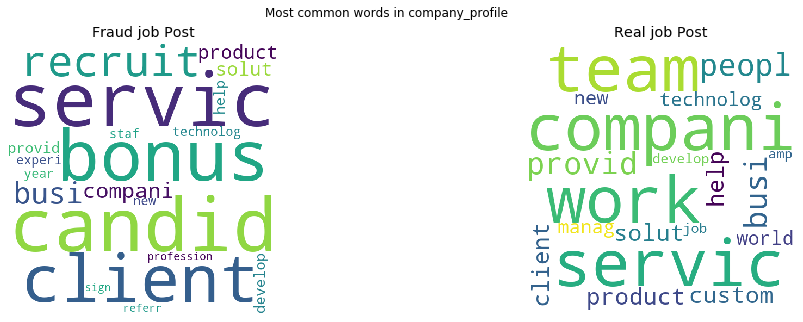

<Figure size 432x288 with 0 Axes>

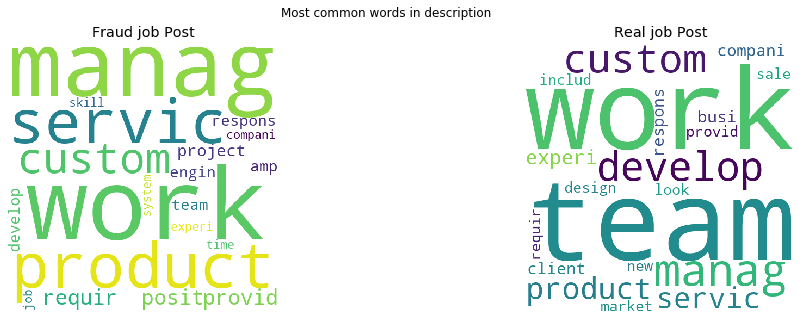

<Figure size 432x288 with 0 Axes>

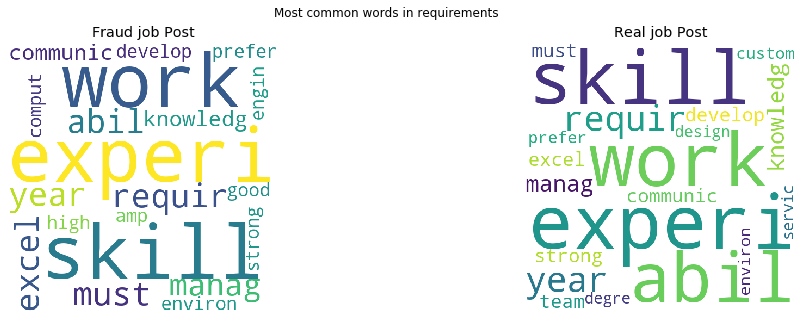

<Figure size 432x288 with 0 Axes>

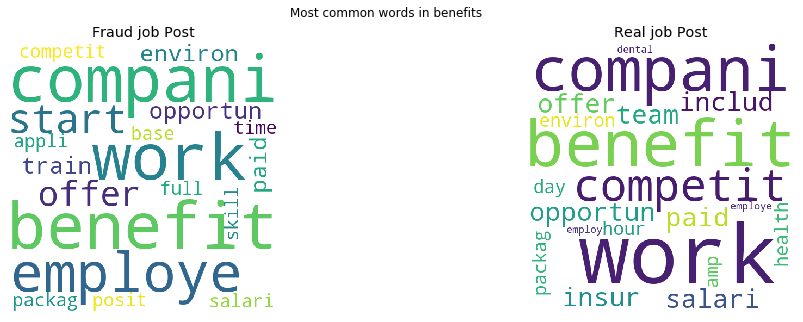

In [433]:
for col in text_cols:
    plot_wordcloud(data, col)

In [434]:
data["text"] = data["title"] + data["company_profile"] + data["description"] + data["requirements"] + data["benefits"]

In [435]:
data.to_pickle("data_text")

## Features Cleaning

In [436]:
df = data.copy()

In [437]:
clean_features(df)

## BASELINE MODEL

In [438]:
# Accuracy is useless in problems with unequal classes and has absolutely no predictive power

In [439]:
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [440]:
y_actual = np.array(df["fraudulent"])

In [441]:
y_pred0 = np.zeros(len(y_actual))
y_pred1 = np.ones(len(y_actual))
pred_y = np.random.choice([0,1],size=(len(y_actual),), p=[0.95,0.05])

In [442]:
cf = confusion_matrix(y_pred0, y_actual)

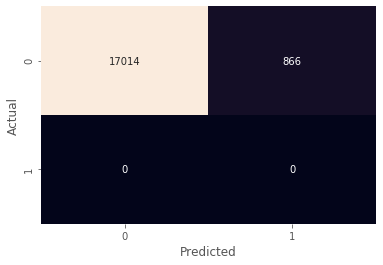

In [443]:
import seaborn as sns
fig = plt.figure()
ax = sns.heatmap(cf, annot=True, cbar=False, fmt='g')
ax.set(xlabel='Predicted', ylabel='Actual')
fig.savefig("images/conf_matrix", bbox_inches='tight')
plt.show()

### Baseline Results

In [444]:
#no frauds
generate_model_report(y_actual, y_pred0)

Accuracy: 0.952
Precision: 0.000
Recall: 0.000
F1 score: 0.000


/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [445]:
#all frauds
generate_model_report(y_actual, y_pred1)

Accuracy: 0.048
Precision: 0.048
Recall: 1.000
F1 score: 0.092


In [446]:
# random prediction
generate_model_report(y_actual,pred_y)

Accuracy: 0.911
Precision: 0.060
Recall: 0.058
F1 score: 0.059


In [447]:
# All categories value except 'department', 'function'

fit_df = df[['location', 'industry', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'text', 'fraudulent']]


In [448]:
cat_df = fit_df[['location', 'industry', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'fraudulent']]

fit_df_dummy = pd.get_dummies(cat_df)



In [449]:
text_cat_df = pd.concat([fit_df_dummy, fit_df["text"]], axis = 1)

In [450]:
text_cat_df.to_pickle("cleaned_textCol.pkl")

## To balance or not to balance

0    17014
1      866
Name: fraudulent, dtype: int64


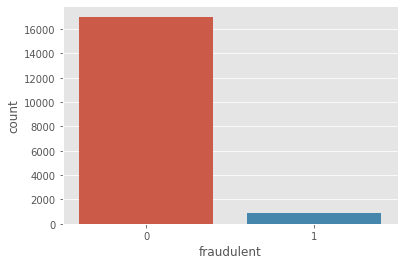

In [451]:
## Split first to avoid leakage and to handle imbalance


X = text_cat_df.drop("fraudulent", axis=1)
y = text_cat_df["fraudulent"]

X_cat, y_cat = fit_df_dummy.drop("fraudulent", axis=1), fit_df_dummy["fraudulent"]

# splitting text and categorical columns
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = .20, random_state=1)

#splitting only categorical columns
X_cat_train, X_cat_test, y_cat_train,y_cat_test = train_test_split(X_cat, y_cat, stratify=y , test_size = .20, random_state=1)


ax = sns.countplot(x = y, data = X)
print(y.value_counts())

# before balancing the data


## SMOTE

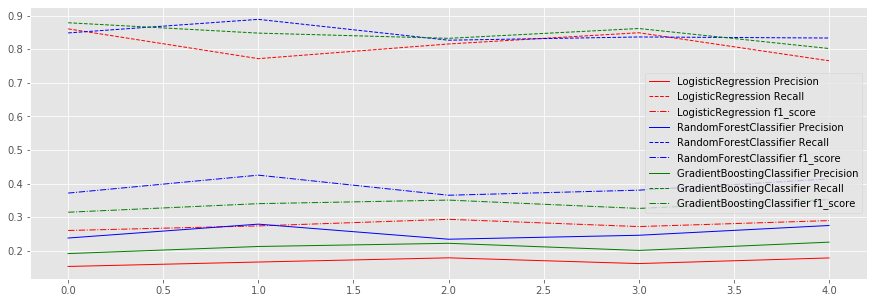

In [452]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators, X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='undersampling' )
ax.legend()

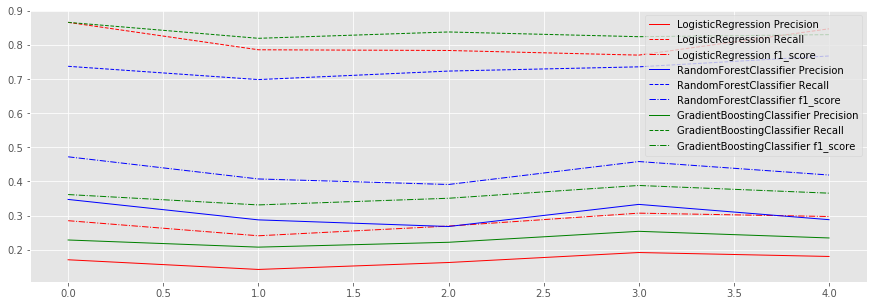

In [453]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='oversampling' )
ax.legend()

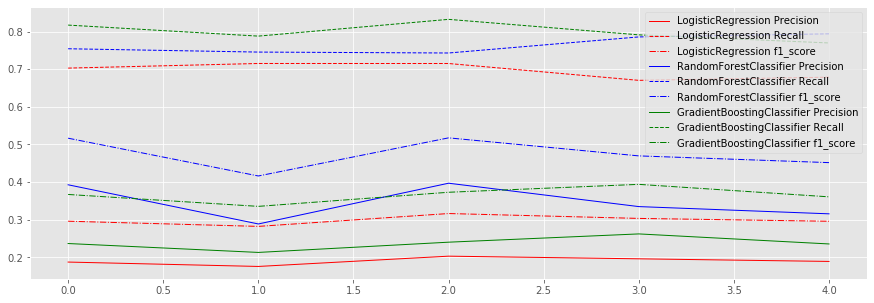

In [454]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='smote' )
ax.legend()

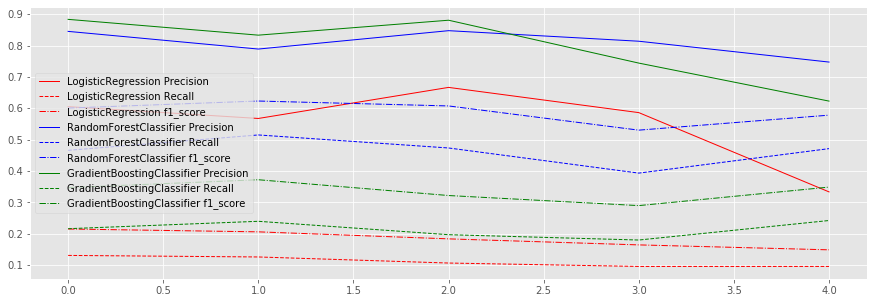

In [455]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='None' )
ax.legend()

## Model only with categorical features

RandomForestClassifier F1 Score:  0.619
RandomForestClassifier PR AUC: 0.685
Accuracy: 0.970
Precision: 0.806
Recall: 0.503
F1 score: 0.619


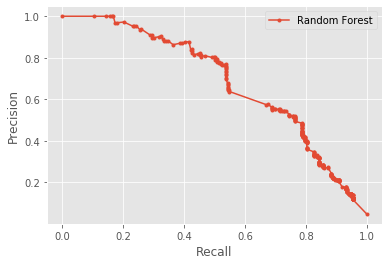

In [456]:
model = RandomForestClassifier()
model.fit(X_cat_train, y_cat_train)

yhat = model.predict_proba(X_cat_test)
pos_probs = yhat[:, 1]


y_pred = model.predict(X_cat_test)


# calculate the precision-recall auc
precision, recall, thresholds = precision_recall_curve(y_cat_test, pos_probs)
F1_Score = f1_score(y_cat_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Random Forest')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)

generate_model_report(y_cat_test, y_pred)
cm = confusion_matrix(y_cat_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

<Figure size 432x288 with 0 Axes>

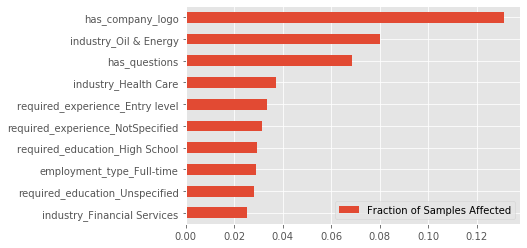

In [457]:
# Plot the feature importance
fig = plt.figure()
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=X_cat_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False)
y = feat_scores[:10]
y[::-1].plot(kind='barh')
fig.savefig(f"images/cat_feature_imp", bbox_inches='tight');

## TFIDF vectorization

In [466]:
tfidf = TfidfVectorizer(max_features = 2000)

In [467]:
tfidf_matrix_train = tfidf.fit_transform(X_train.text.values.astype('U'))

In [468]:
tfidf_matrix_test =  tfidf.transform(X_test.text.values.astype('U'))

In [469]:
import pickle
pickle.dump(tfidf, open("tfidf.pkl", "wb"))

In [462]:
nlp_train = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf.get_feature_names())
nlp_test = pd.DataFrame(tfidf_matrix_test.toarray(), columns=tfidf.get_feature_names())

In [463]:
nlp_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
cat_nlp_train = pd.concat([nlp_train, X_train], axis=1)

nlp_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
cat_nlp_test = pd.concat([nlp_test, X_test], axis=1)

In [464]:
cat_nlp_train = cat_nlp_train.drop("text", axis=1)
cat_nlp_test = cat_nlp_test.drop("text", axis=1);

cat_nlp_test.to_pickle("cat_nlp_test.pkl")

No Skill F1 Score: 0.017
No Skill PR AUC: 0.077
Accuracy: 0.904
Precision: 0.017
Recall: 0.017
F1 score: 0.017


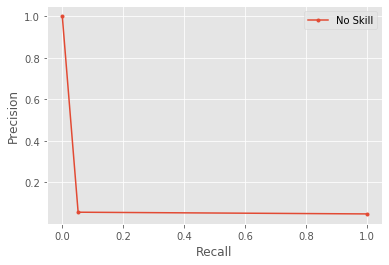

In [47]:
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot


# setting up a dummy model
model = DummyClassifier(strategy='stratified')  #Predict 0 or 1 proportional to the prior probability in the dataset 
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
y_pred = model.predict(cat_nlp_test)
pos_probs = yhat[:, 1]



# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='No Skill')
print('No Skill F1 Score: %.3f' % F1_Score)
print('No Skill PR AUC: %.3f' % auc_score)

generate_model_report(y_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.270000, F-Score=0.842
Best Threshold=0.270000, Precision=0.870, Recall=0.815




RandomForestClassifier F1 Score:  0.742
RandomForestClassifier PR AUC: 0.897
Accuracy: 0.980
Precision: 1.000
Recall: 0.590
F1 score: 0.742


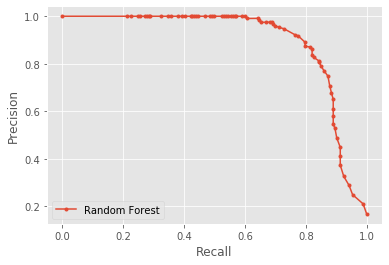

In [465]:
model = RandomForestClassifier()
model.fit(cat_nlp_train, y_train)

yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]


y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, thresholds = precision_recall_curve(y_test, pos_probs)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Best Threshold=%f, Precision=%.3f, Recall=%.3f'  % (thresholds[ix], precision[ix], recall[ix]))
print("\n\n\n")
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Random Forest')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)

generate_model_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [50]:
import pickle
pickle.dump(model, open("model.pkl", "wb"))

## Plot the feature importance

<Figure size 432x288 with 0 Axes>

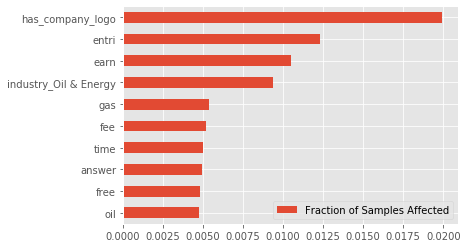

In [470]:
fig = plt.figure()
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=cat_nlp_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending = False)[:10]
y = feat_scores[:10]
y[::-1].plot(kind="barh")
fig.savefig(f"images/text_feature_imp", bbox_inches='tight');

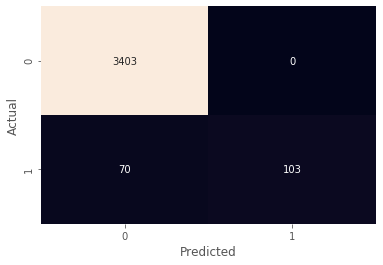

In [51]:
import seaborn as sns
fig = plt.figure()
ax = sns.heatmap(cm , annot=True, cbar=False, fmt='g')
ax.set(xlabel='Predicted', ylabel='Actual')
fig.savefig("images/conf_matrix", bbox_inches='tight')
plt.show()

GradientBoostingClassifier F1 Score:  0.664
GradientBoostingClassifier PR AUC: 0.742
Accuracy: 0.974
Precision: 0.869
Recall: 0.538
F1 score: 0.664


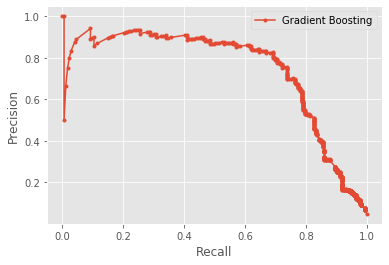

In [52]:
model = GradientBoostingClassifier()
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]
y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Gradient Boosting')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)
generate_model_report(y_test, y_pred)



# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

LogisticRegression F1 Score:  0.664
LogisticRegression PR AUC: 0.789
Accuracy: 0.974
Precision: 0.901
Recall: 0.526
F1 score: 0.664


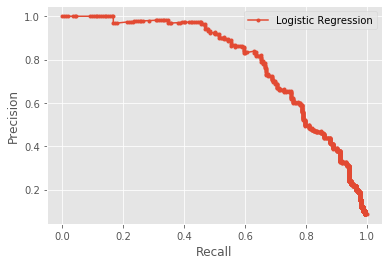

In [53]:
model = LogisticRegression(max_iter=500)
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]
y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Logistic Regression')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)
generate_model_report(y_test, y_pred)


# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# LSTM

In [54]:
lstm_df = pd.read_pickle("cleaned_textCol.pkl")

In [55]:
lstm_df = lstm_df[["text", "fraudulent"]]

In [ ]:
lstm_df = lstm_df.reset_index(drop=True)

In [56]:
lstm_df.fraudulent = lstm_df.fraudulent.replace([0,1],["Not fraud","fraud"])

In [57]:
lstm_df.text = lstm_df.text.apply(clean_text)
lstm_df.text = lstm_df.text.str.replace('\d+', '')

In [58]:
X = lstm_df.text
y = lstm_df.fraudulent

In [59]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [471]:
y = le.fit_transform(y)
y.reshape(-1,1);

/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.20)

In [62]:
import tensorflow as tf
keras = tf.keras

# The maximum number of words to be used. (most frequent)
max_words = 60000
# Max number of words in each complaint.
max_length = 250
# This is fixed.
embedding_dim = 100


tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 59332 unique tokens.


In [63]:
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length)
print('Shape of data tensor:', sequences_matrix.shape)

Shape of data tensor: (14304, 250)


In [73]:
from keras.layers import Embedding, LSTM, Dense, Input, Activation, Dropout
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

In [74]:
model = Sequential()
model.add(Embedding(max_words,150,input_length=max_length))
model.add(LSTM(64))

model.add(Dense(32, name="FC1"))
model.add(Activation("relu"))
# model.add(Dropout(0.4))

model.add(Dense(16, activation=tf.nn.relu))
model.add(Dropout(0.4))

model.add(Dense(1,name="out_layer"))
model.add(Activation("sigmoid"))

In [75]:
import keras.backend as K

def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

In [76]:
model.summary()
model.compile(loss="binary_crossentropy", optimizer=RMSprop(), metrics=["accuracy", precision, recall, f1_score])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 150)          9000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                55040     
_________________________________________________________________
FC1 (Dense)                  (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

In [77]:
model.fit(sequences_matrix, Y_train, batch_size=150, epochs=5, validation_split=.20, 
          callbacks=[EarlyStopping(monitor="val_loss", min_delta=0.0001)])

Epoch 1/5
77/77 [==============================] - 52s 677ms/step - loss: 0.2156 - accuracy: 0.9500 - precision: 0.3934 - recall: 0.1292 - f1_score: 0.1806 - val_loss: 0.1182 - val_accuracy: 0.9682 - val_precision: 0.7500 - val_recall: 0.3082 - val_f1_score: 0.4280
Epoch 2/5
77/77 [==============================] - 55s 709ms/step - loss: 0.1049 - accuracy: 0.9726 - precision: 0.8858 - recall: 0.5086 - f1_score: 0.6196 - val_loss: 0.1109 - val_accuracy: 0.9678 - val_precision: 0.6690 - val_recall: 0.5287 - val_f1_score: 0.5748
Epoch 3/5
77/77 [==============================] - 55s 718ms/step - loss: 0.0689 - accuracy: 0.9822 - precision: 0.9037 - recall: 0.7199 - f1_score: 0.7840 - val_loss: 0.1219 - val_accuracy: 0.9731 - val_precision: 0.7733 - val_recall: 0.4430 - val_f1_score: 0.5517


In [78]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequence_matrix = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length)

In [79]:
accr = model.evaluate(test_sequence_matrix, Y_test)

112/112 [==============================] - 5s 42ms/step - loss: 0.0951 - accuracy: 0.9796 - precision: 0.5179 - recall: 0.4268 - f1_score: 0.4528


In [80]:
print(f"Test set\n Loss:{accr[0]}\n Accuracy: {accr[1]}\n Precision: {accr[2]}\n Recall: {accr[3]}\n F1 Score: {accr[4]}")

Test set
 Loss:0.0951220691204071
 Accuracy: 0.979586124420166
 Precision: 0.5178571343421936
 Recall: 0.4267857074737549
 F1 Score: 0.4527849555015564


In [81]:
# test_case = ["software team team company experience work health software development"]
# test_case = ["data entry at home bonus entri data entri"]
txts=tokenizer.texts_to_sequences(test_case)
txts = tf.keras.preprocessing.sequence.pad_sequences(txts,maxlen=max_length)

In [82]:
pred = model.predict(txts)
print(pred)

[[0.07801962]]
